In [2]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

def preprocess_images_folder(folder_path, resolution=(32, 32)):
    tensor_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Preprocess the image and append the tensor to the list
            image_path = os.path.join(folder_path, filename)
            tensor = preprocess_image(image_path,
                                      normalize=True,
                                      keep_alpha=False,
                                      resolution=resolution)
            tensor_list.append(tensor)
    # Stack the list of tensors into a single tensor
    tensor_stack = torch.stack(tensor_list)
    tensor_stack = tensor_stack.squeeze()  # remove the singleton dimension
    return tensor_stack

def preprocess_image(image_path,
                     normalize=True,
                     keep_alpha=False,
                     resolution=(32, 32)):
    # Load the image using PIL
    image = Image.open(image_path)

    # Check if the image has an alpha channel
    has_alpha = image.mode.endswith('A')

    # Convert the image to RGB if it has an alpha channel and we're not keeping it
    if has_alpha and not keep_alpha:
        image = image.convert('RGB')

    # Resize the image to 32x32 pixels
    image = image.resize(resolution)

    # Convert the image to a PyTorch tensor
    if keep_alpha:
        # If we're keeping the alpha channel, convert the image to a 4D tensor with shape (1, 4, 32, 32)
        tensor = transforms.functional.to_tensor(image).unsqueeze(0)
    else:
        # If we're not keeping the alpha channel, convert the image to a 3D tensor with shape (1, 3, 32, 32)
        tensor = transforms.functional.to_tensor(image).unsqueeze(0)[:, :3]

    # Normalize the tensor if requested
    if normalize:
        if keep_alpha:
            # If we're keeping the alpha channel, normalize using a mean and std for a 4D tensor
            mean = torch.tensor([0.5, 0.5, 0.5, 0.5])
            std = torch.tensor([0.5, 0.5, 0.5, 0.5])
        else:
            # If we're not keeping the alpha channel, normalize using a mean and std for a 3D tensor
            mean = torch.tensor([0.5, 0.5, 0.5])
            std = torch.tensor([0.5, 0.5, 0.5])
        tensor = transforms.functional.normalize(tensor, mean=mean, std=std)

    return tensor


def preprocess_images_folder(folder_path, resolution=(32, 32)):
    tensor_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Preprocess the image and append the tensor to the list
            image_path = os.path.join(folder_path, filename)
            tensor = preprocess_image(image_path,
                                      normalize=True,
                                      keep_alpha=False,
                                      resolution=resolution)
            tensor_list.append(tensor)
    # Stack the list of tensors into a single tensor
    tensor_stack = torch.stack(tensor_list)
    tensor_stack = tensor_stack.squeeze()  # remove the singleton dimension

    return tensor_stack


def create_train_loader(tensor_stack, batch_size=32, shuffle=True):
    # Create a dataset from the tensor stack
    dataset = TensorDataset(tensor_stack)

    # Create a dataloader from the dataset
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader



pokemon = preprocess_images_folder(
    '/Users/juan-garassino/Code/juan-garassino/miniTransformer/miniTransformer/data/pokemon',
    resolution=(32, 32))

train_loader = create_train_loader(pokemon,
                                                 batch_size=32,
                                                 shuffle=True)


In [3]:
pokemon.shape

torch.Size([819, 3, 32, 32])

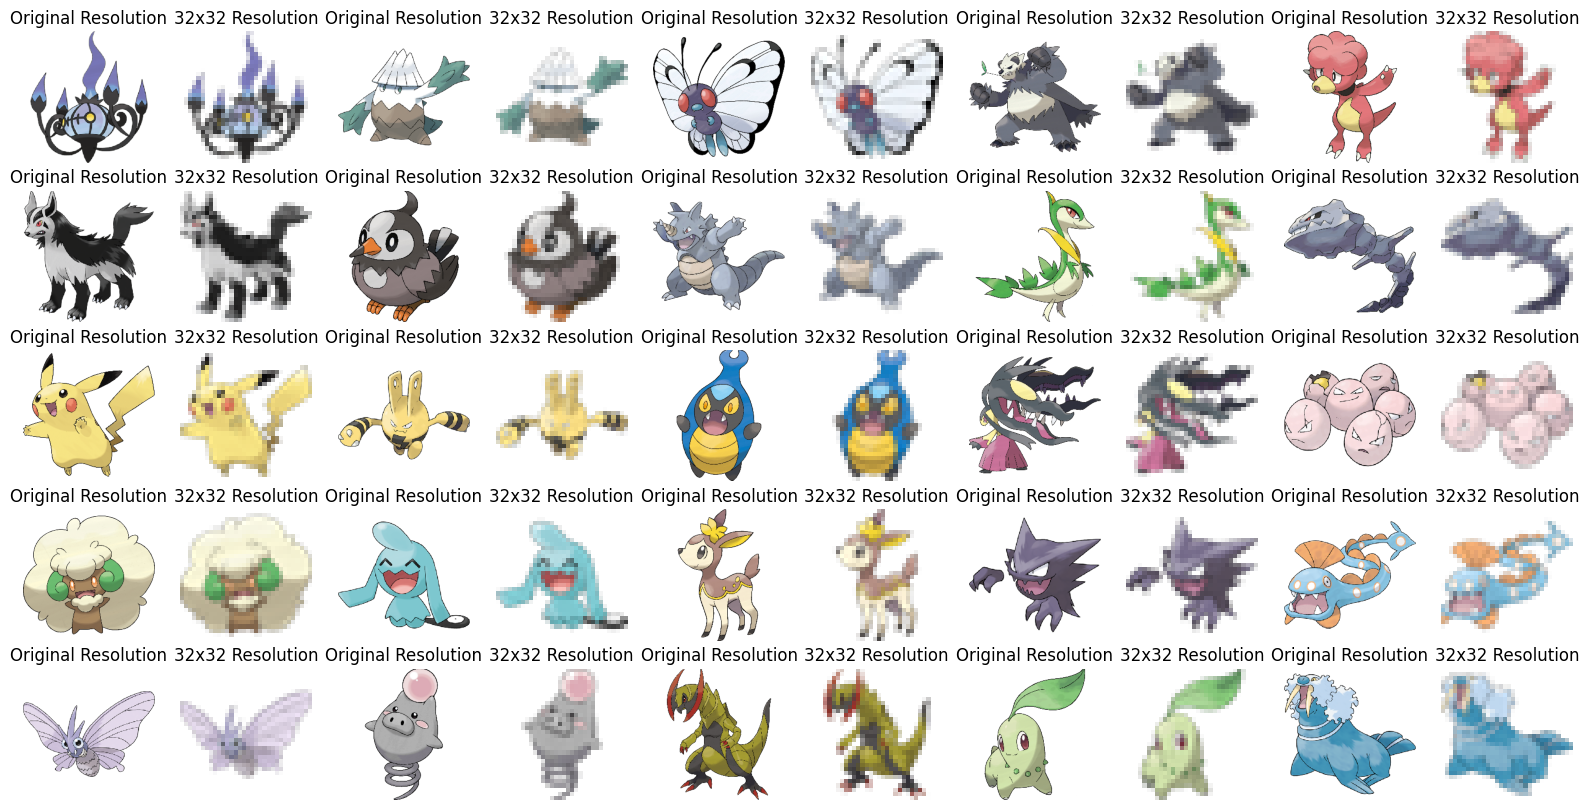

In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


def display_images(folder_path, resolution):
    # Get a list of all image file paths in the folder
    image_paths = [
        os.path.join(folder_path, f) for f in os.listdir(folder_path)
        if f.endswith('.jpg') or f.endswith('.png')
    ]

    # Select 25 random images from the list
    selected_images = random.sample(image_paths, 25)

    # Set up the matplotlib figure with two subplots
    fig, axs = plt.subplots(5, 10, figsize=(20, 10))

    # Loop through each selected image, preprocess it, and display it
    for i, image_path in enumerate(selected_images):
        # Load the image using PIL
        image = Image.open(image_path)

        # Display the image in the original resolution
        axs[i // 5, i % 5 * 2].imshow(image)
        axs[i // 5, i % 5 * 2].set_title('Original Resolution')
        axs[i // 5, i % 5 * 2].axis('off')

        # Resize the image to the specified resolution
        new_image = image.resize((resolution, resolution))

        # Display the image in the new resolution
        axs[i // 5, i % 5 * 2 + 1].imshow(new_image)
        axs[i // 5,
            i % 5 * 2 + 1].set_title(f'{resolution}x{resolution} Resolution')
        axs[i // 5, i % 5 * 2 + 1].axis('off')

    # Show the plot
    plt.show()

display_images(
    '/Users/juan-garassino/Code/juan-garassino/miniTransformer/miniTransformer/data/pokemon', 32
)


In [5]:
import torch.nn as nn


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        return x


class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.up1(x)
        x = nn.functional.relu(self.conv1(x))
        x = self.up2(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.up3(x)
        x = nn.functional.relu(self.conv3(x))
        return x


class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
encoder = Encoder()

encoded_pokemon = encoder(pokemon)

encoded_pokemon.shape

torch.Size([819, 128, 4, 4])

In [7]:
autoencoder = Autoencoder()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 1/26] Loss: 0.694930


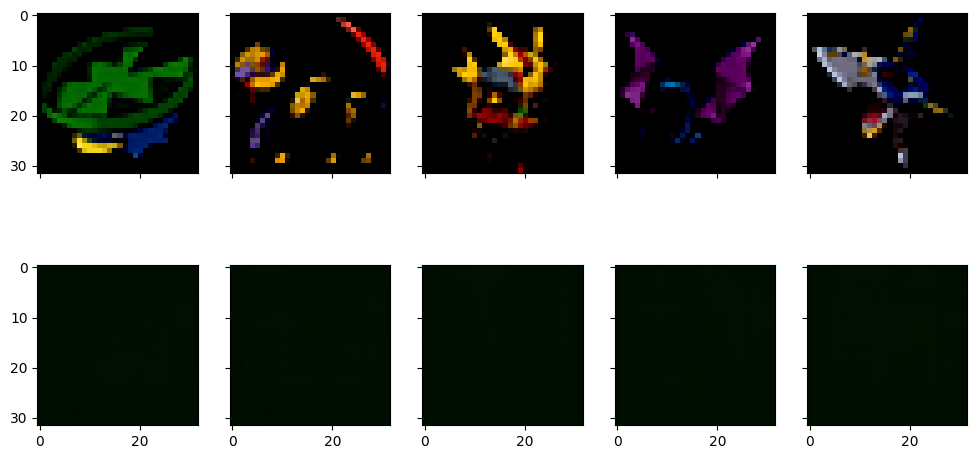

[Epoch 1, Iter 2/26] Loss: 0.689478


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


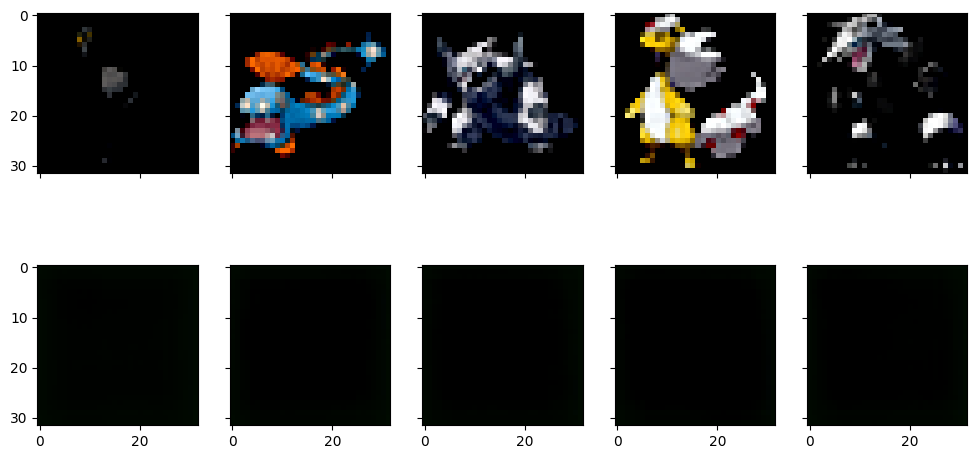

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 3/26] Loss: 0.674646


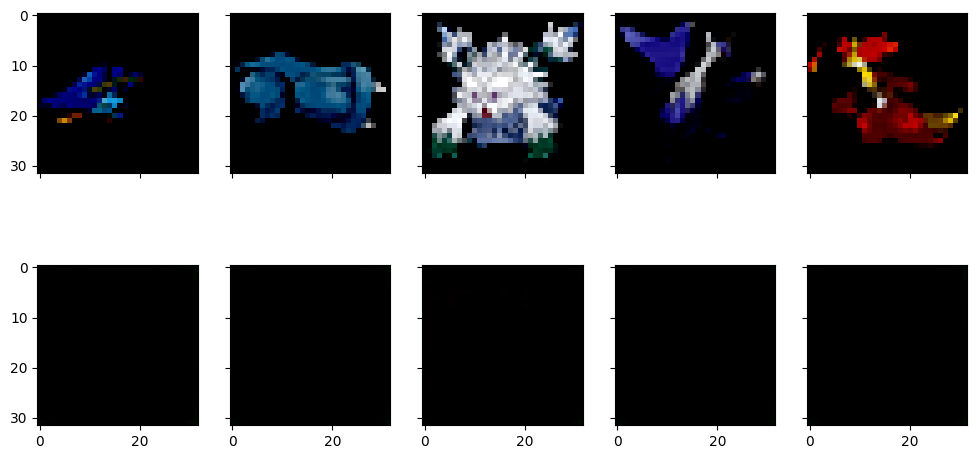

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 4/26] Loss: 0.645093


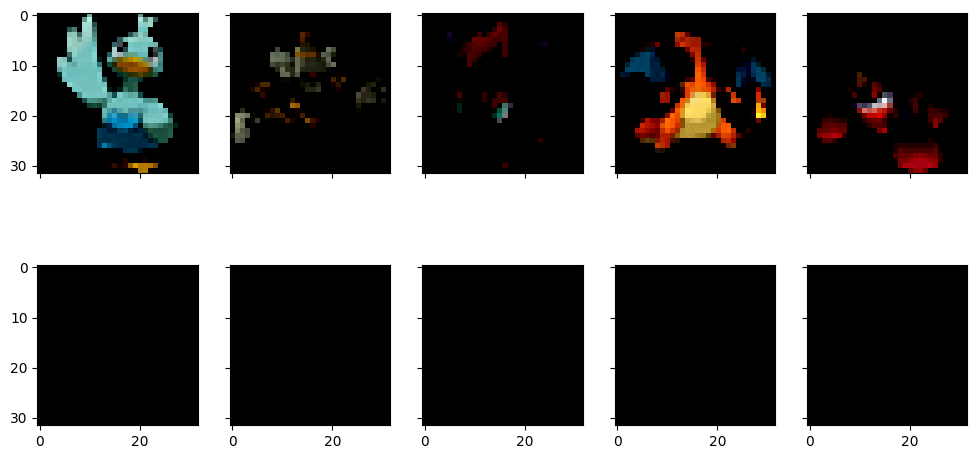

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 5/26] Loss: 0.670994


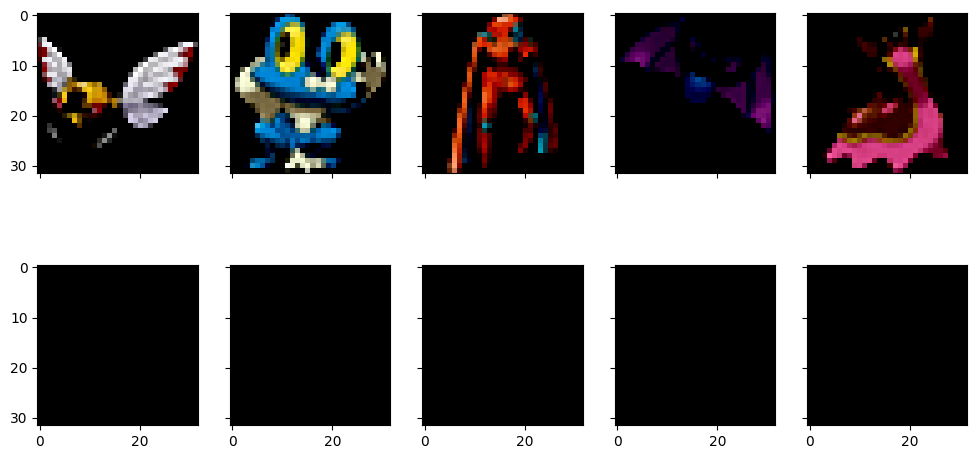

[Epoch 1, Iter 6/26] Loss: 0.677815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


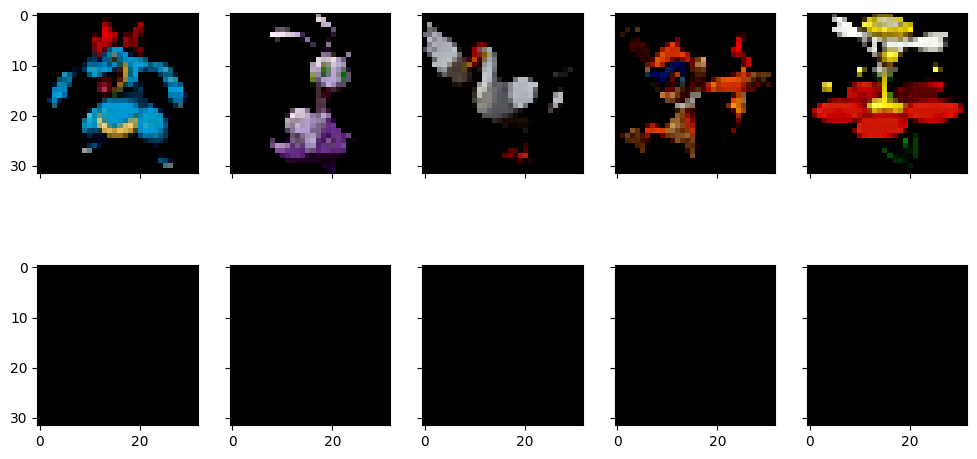

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 7/26] Loss: 0.671173


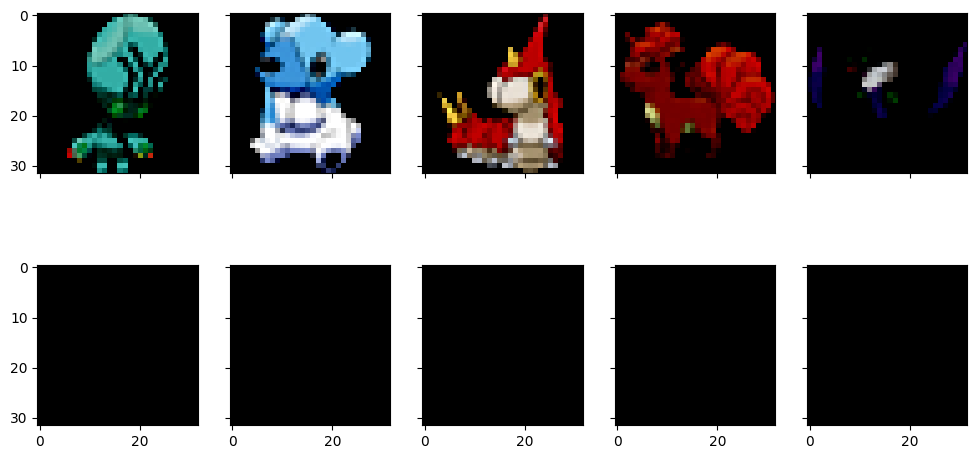

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 8/26] Loss: 0.668797


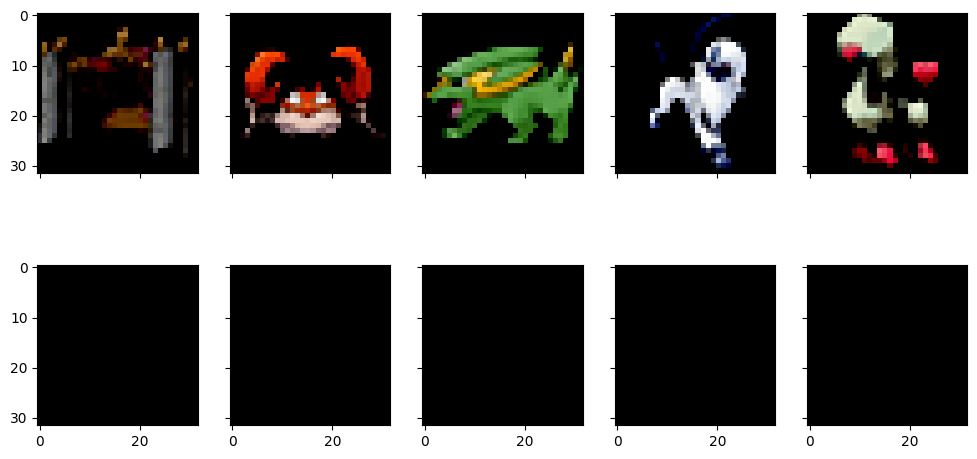

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 9/26] Loss: 0.679014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


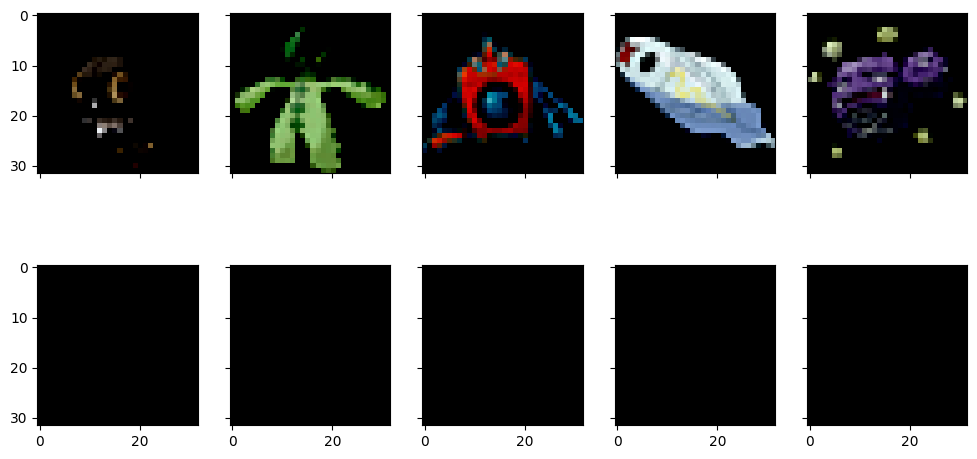

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 10/26] Loss: 0.680315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


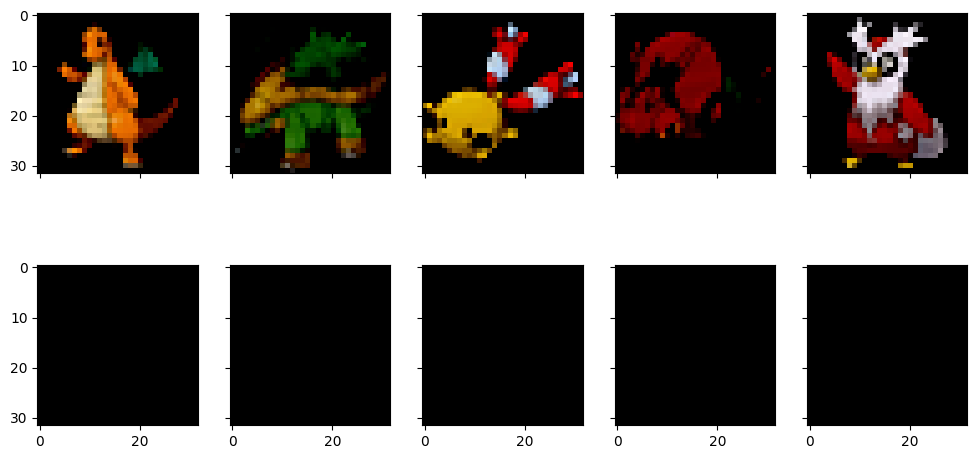

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 11/26] Loss: 0.661109


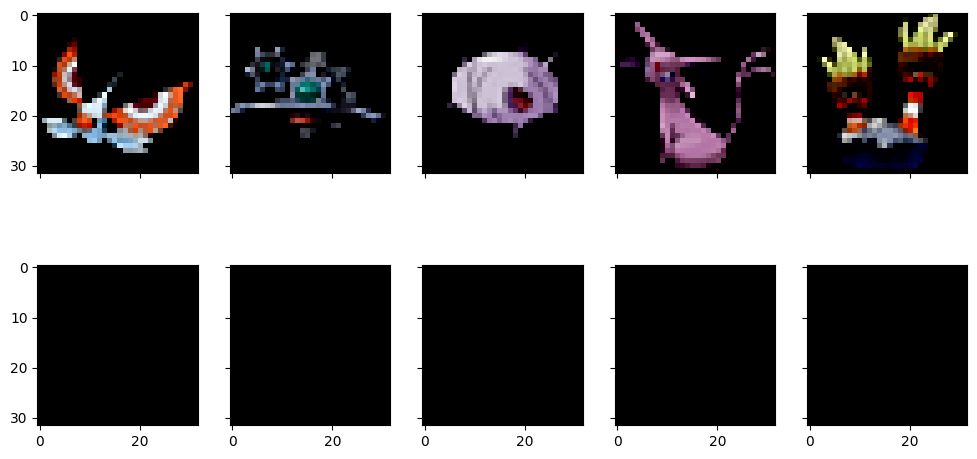

[Epoch 1, Iter 12/26] Loss: 0.663179


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


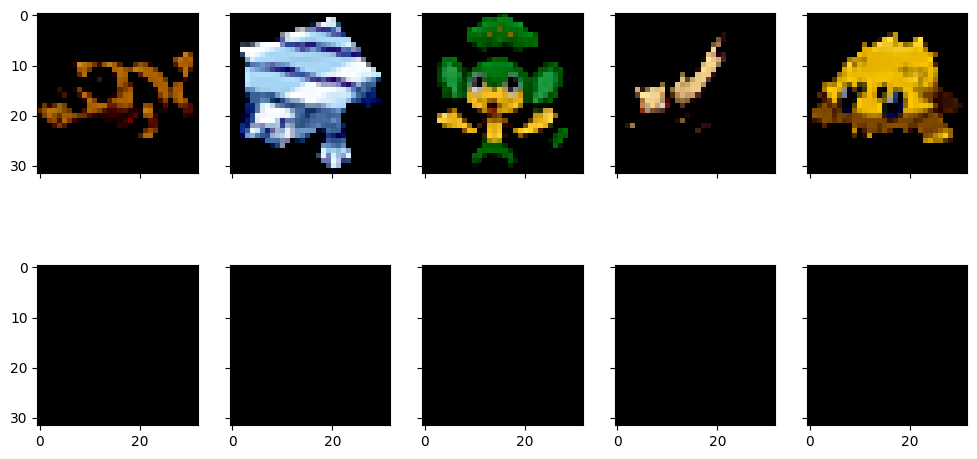

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 13/26] Loss: 0.698132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


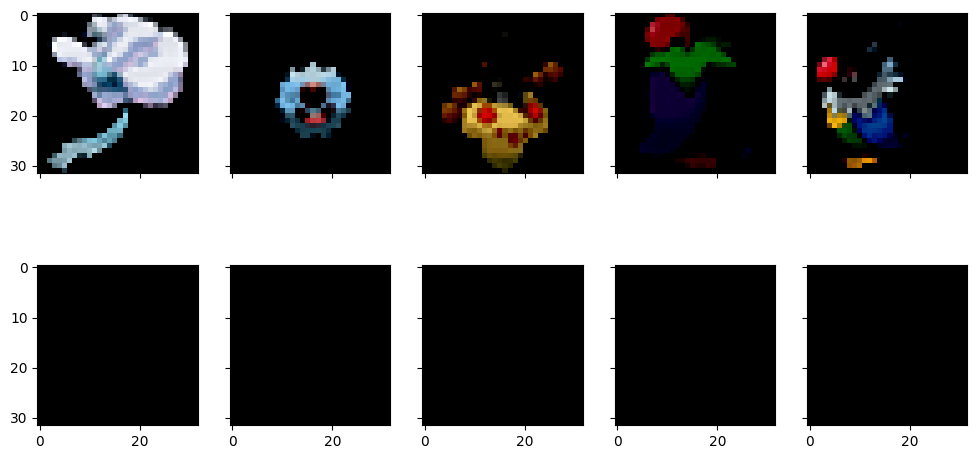

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 14/26] Loss: 0.645396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


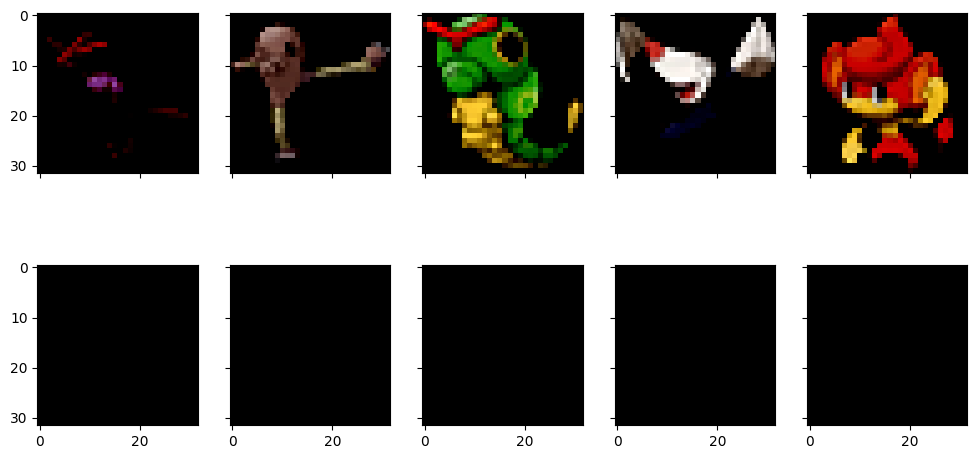

[Epoch 1, Iter 15/26] Loss: 0.696167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


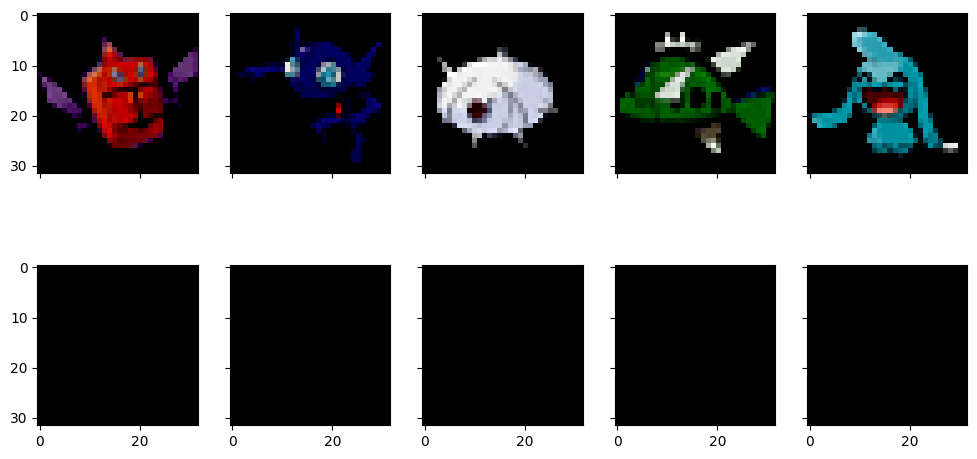

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 16/26] Loss: 0.661563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


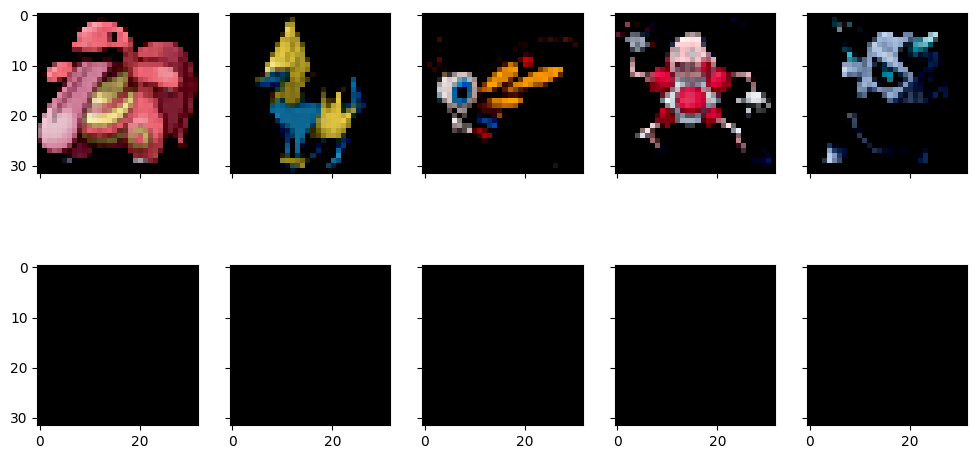

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 17/26] Loss: 0.664175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


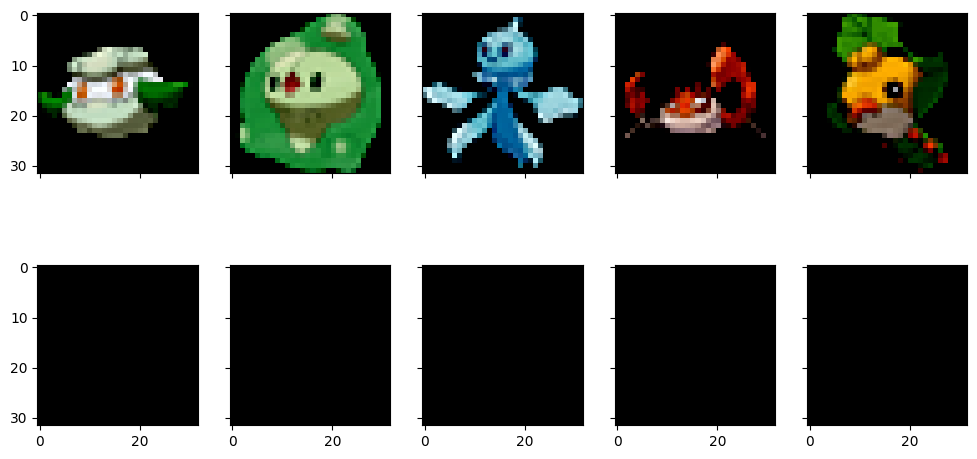

[Epoch 1, Iter 18/26] Loss: 0.652836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


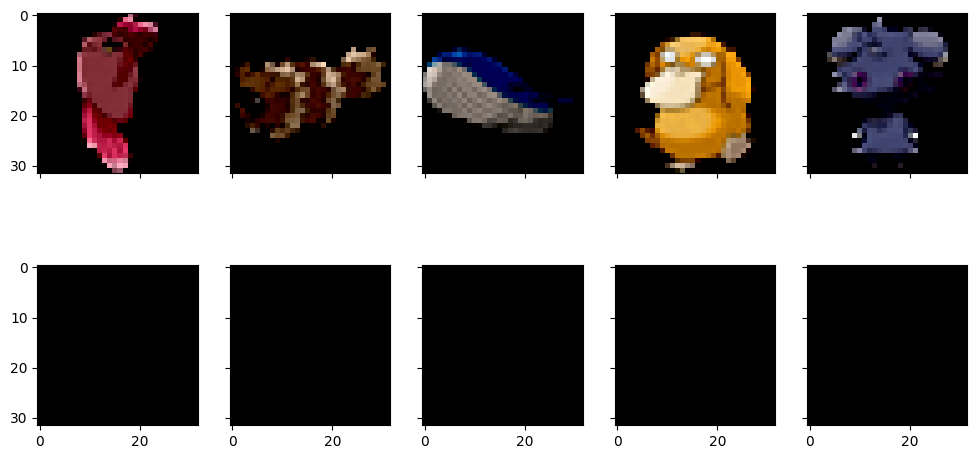

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 19/26] Loss: 0.638967


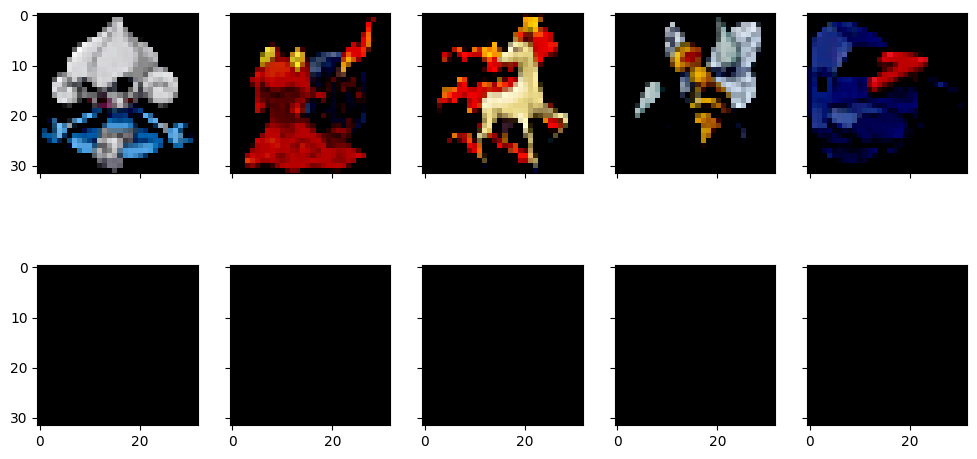

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 20/26] Loss: 0.668785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


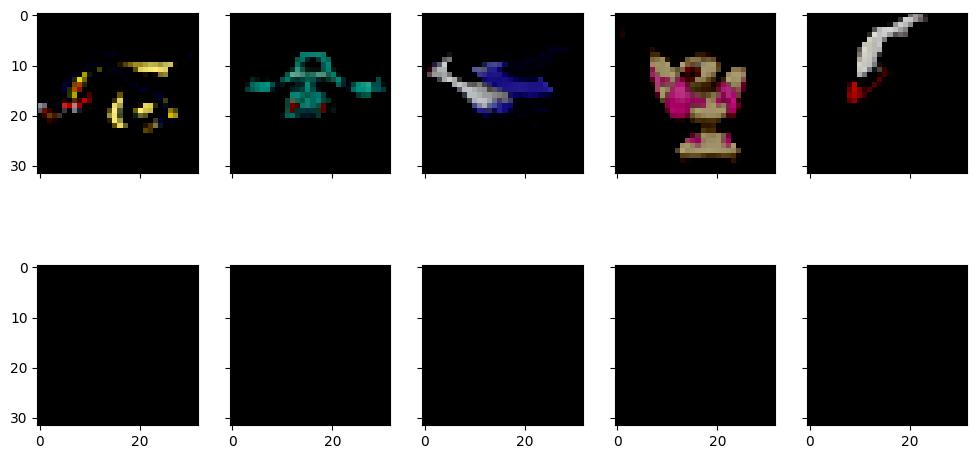

[Epoch 1, Iter 21/26] Loss: 0.629875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


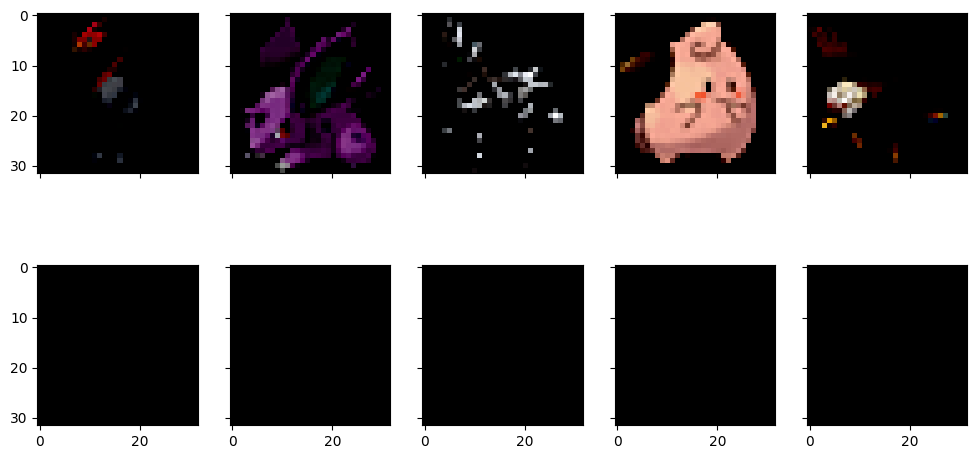

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 22/26] Loss: 0.646565


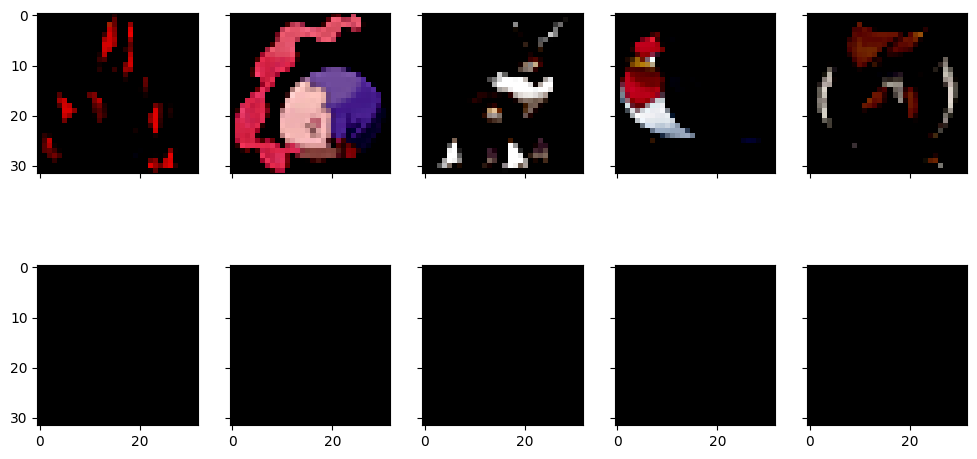

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 23/26] Loss: 0.657290


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


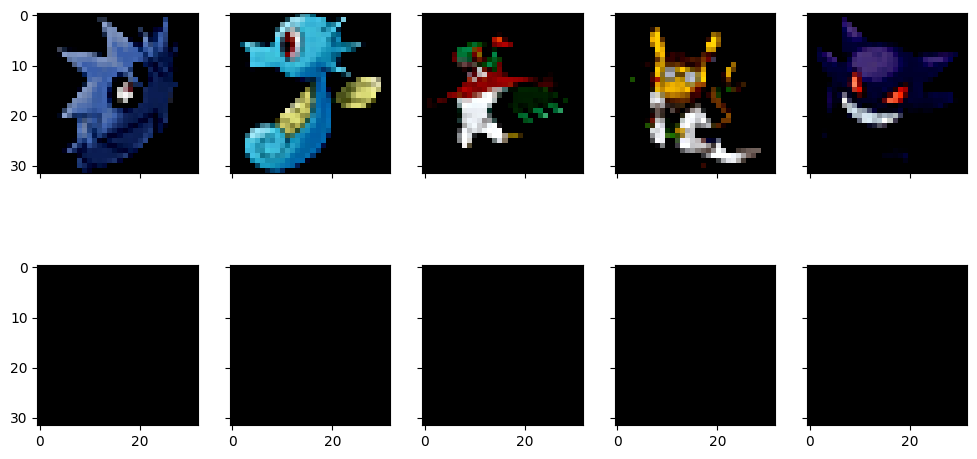

[Epoch 1, Iter 24/26] Loss: 0.649411


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


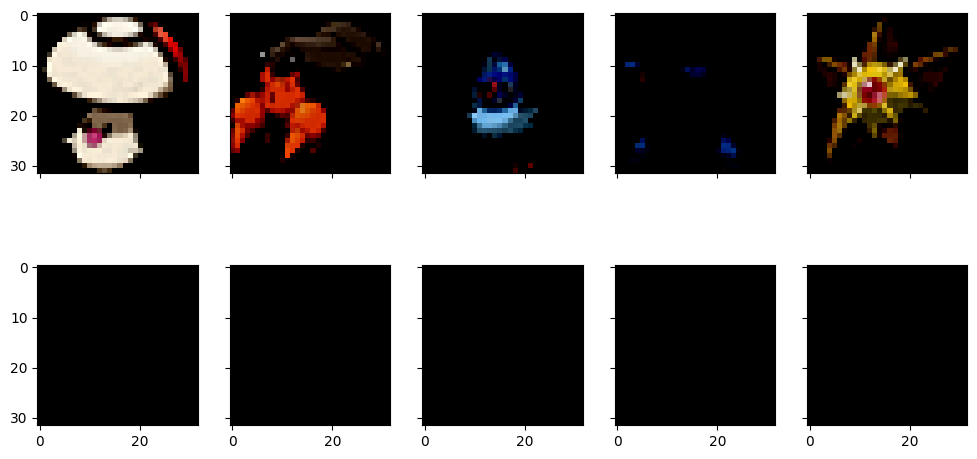

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 25/26] Loss: 0.639258


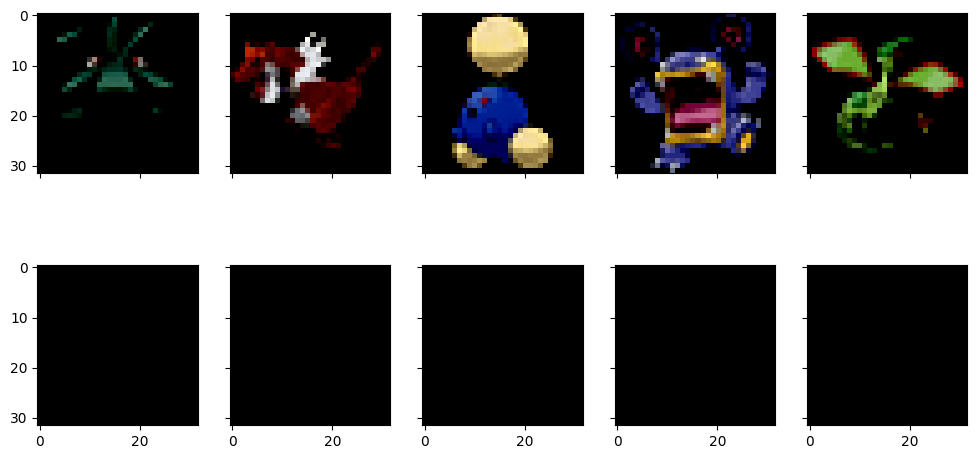

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1, Iter 26/26] Loss: 0.635619


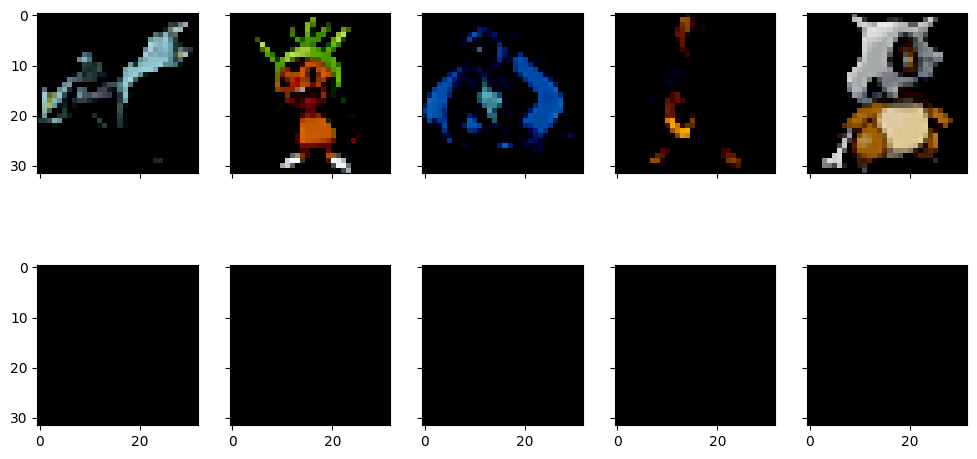

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 1/26] Loss: 0.652832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


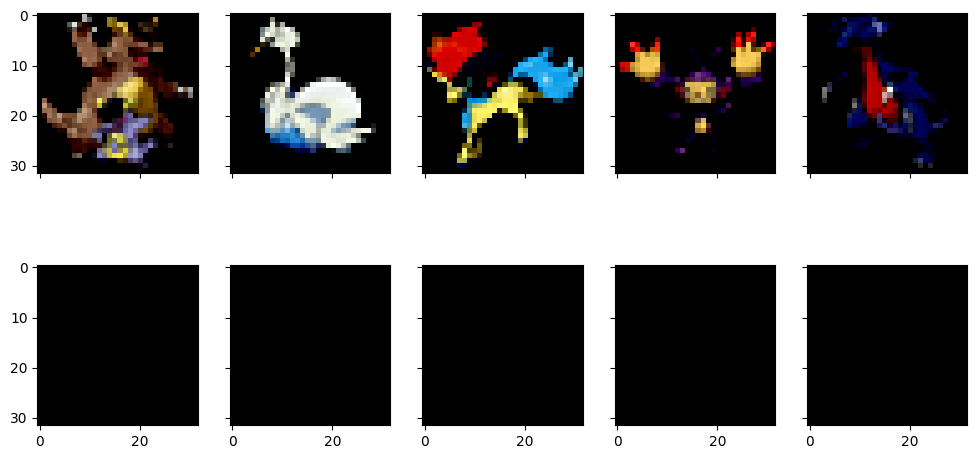

[Epoch 2, Iter 2/26] Loss: 0.667060


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


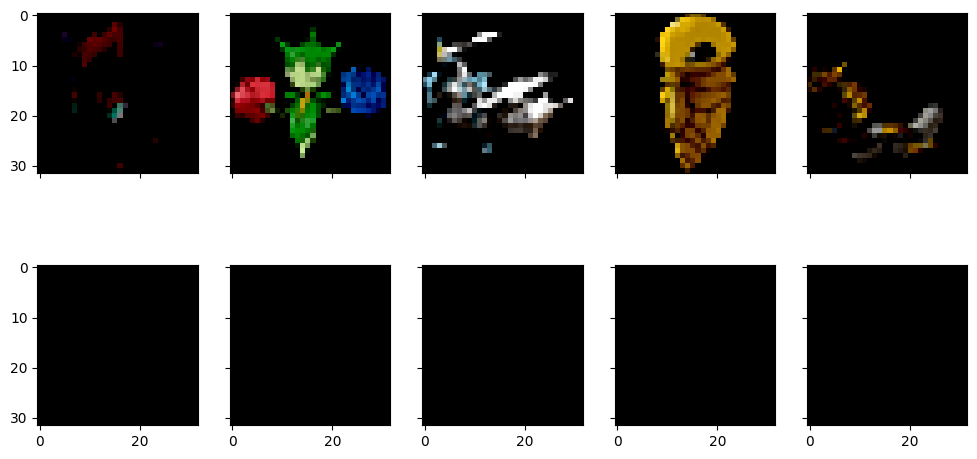

[Epoch 2, Iter 3/26] Loss: 0.637084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


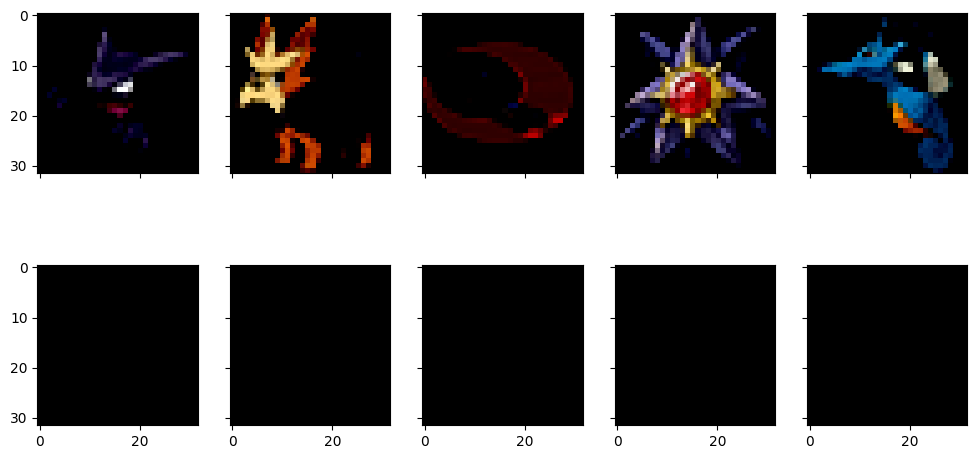

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 4/26] Loss: 0.657906


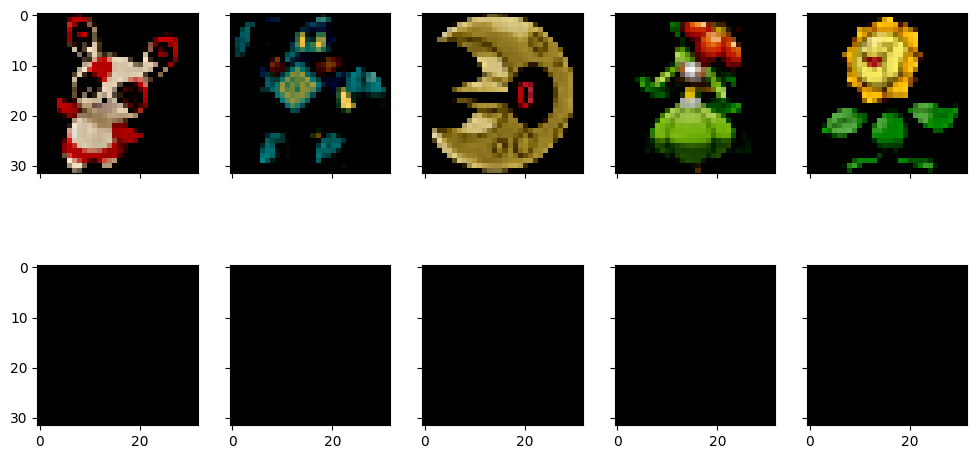

[Epoch 2, Iter 5/26] Loss: 0.644697


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


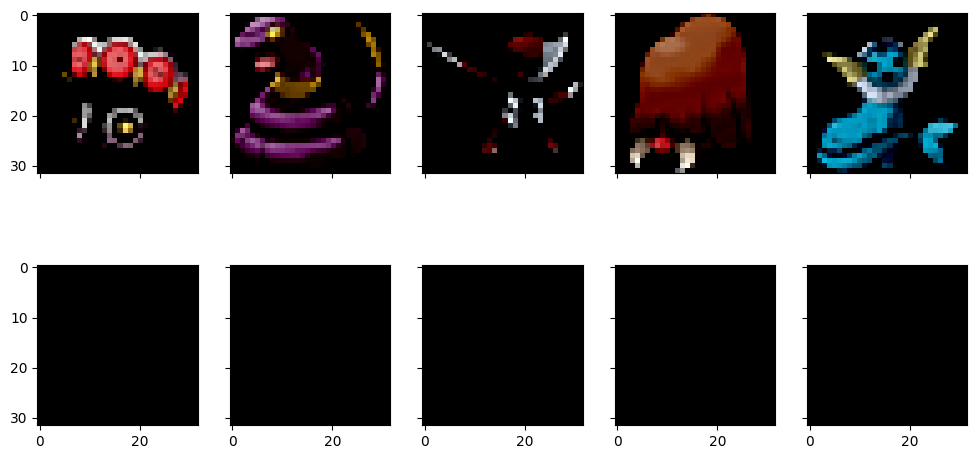

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 6/26] Loss: 0.647892


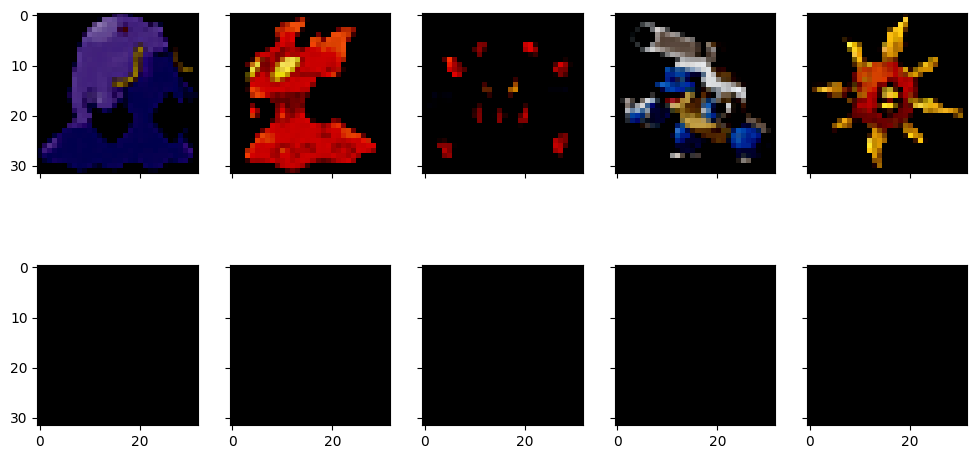

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 7/26] Loss: 0.675839


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


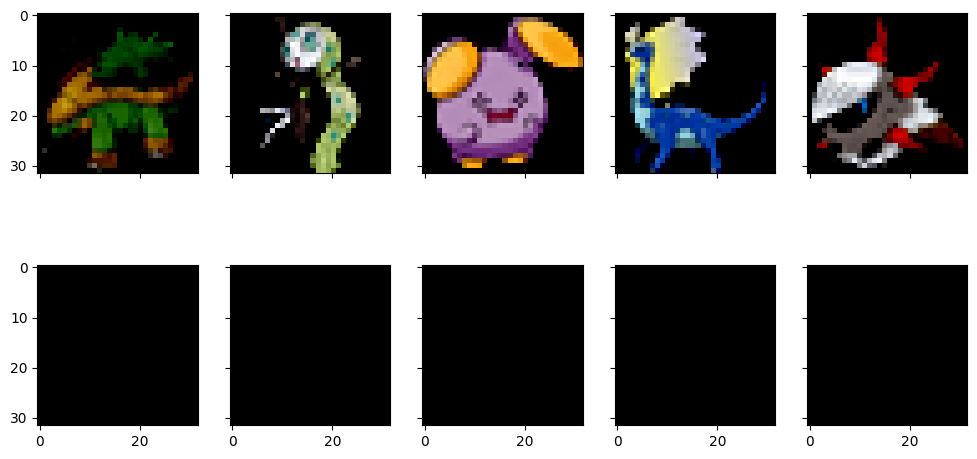

[Epoch 2, Iter 8/26] Loss: 0.675653


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


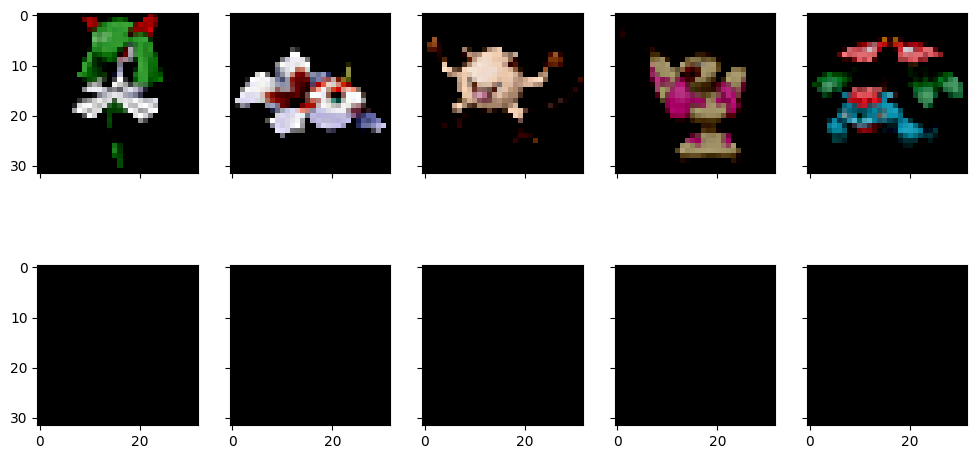

[Epoch 2, Iter 9/26] Loss: 0.649955


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


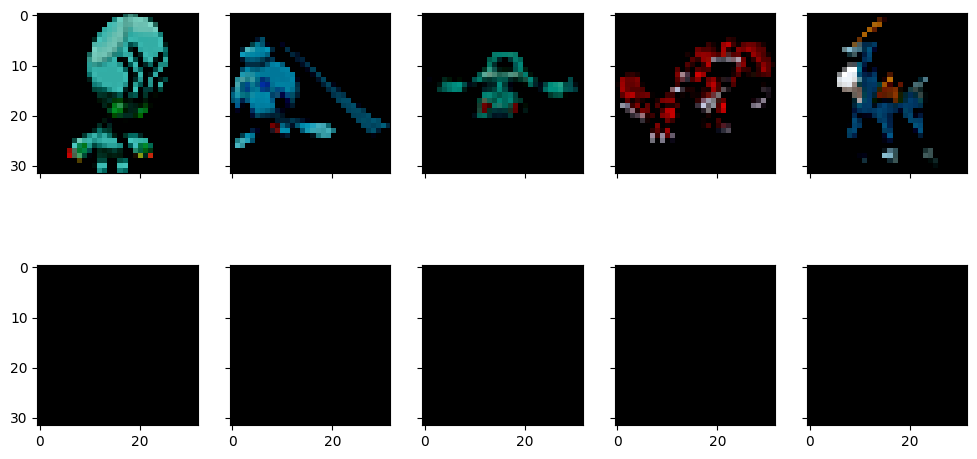

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 10/26] Loss: 0.678517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


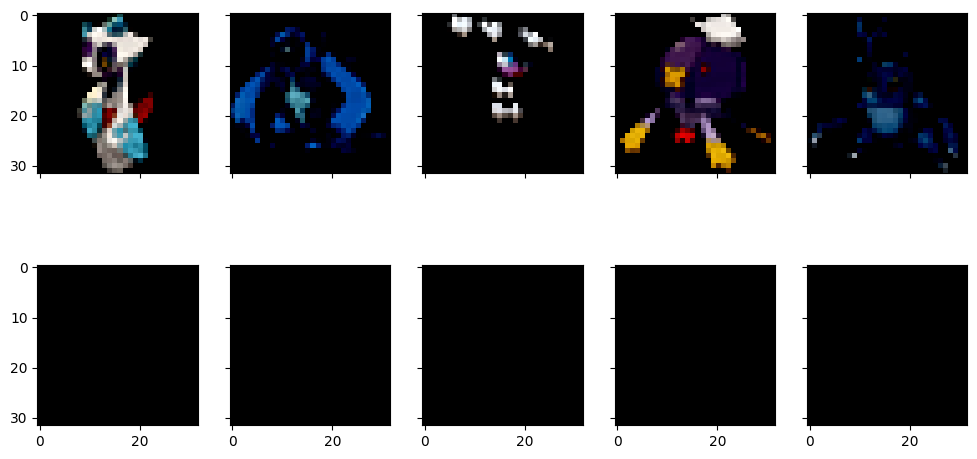

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 11/26] Loss: 0.666727


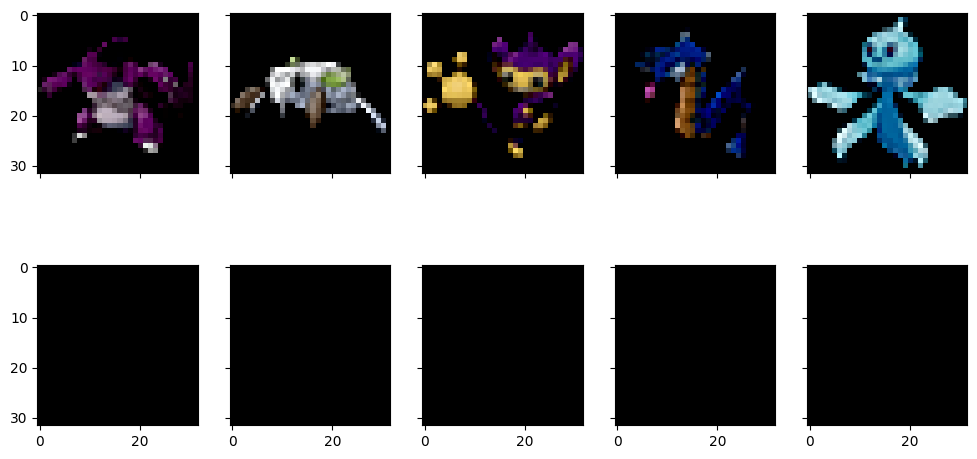

[Epoch 2, Iter 12/26] Loss: 0.654843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


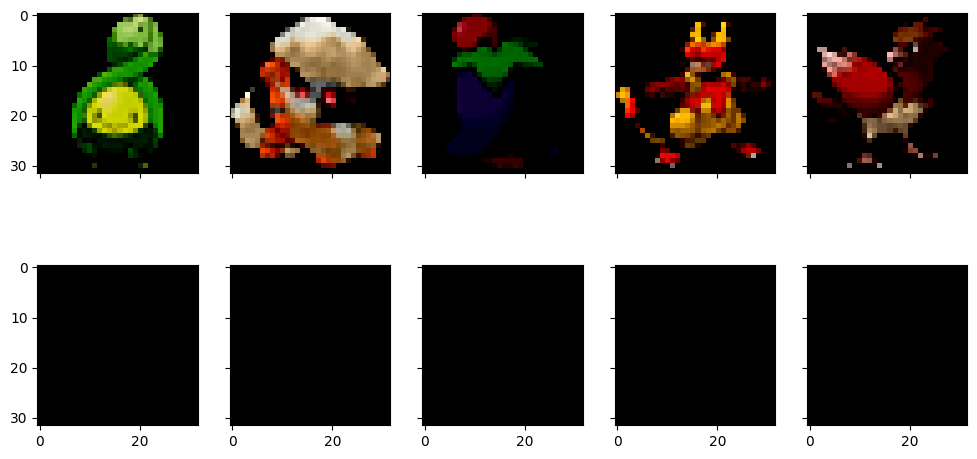

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 13/26] Loss: 0.691449


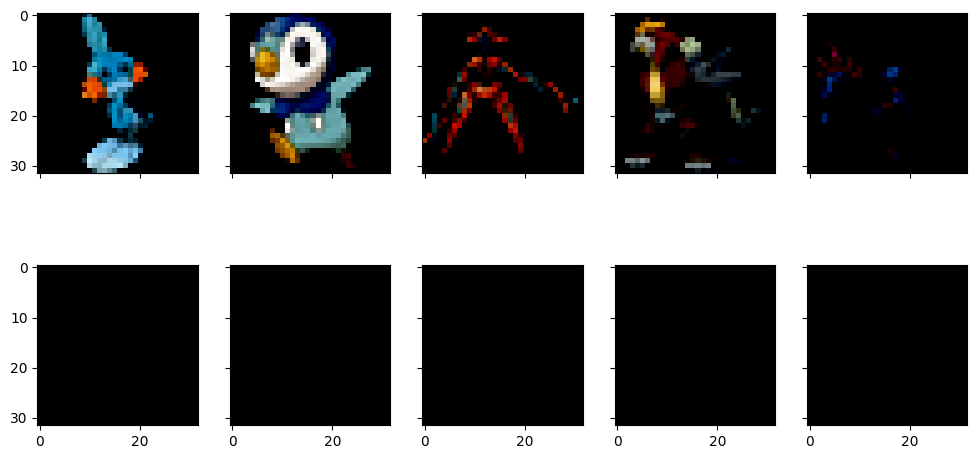

[Epoch 2, Iter 14/26] Loss: 0.654707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


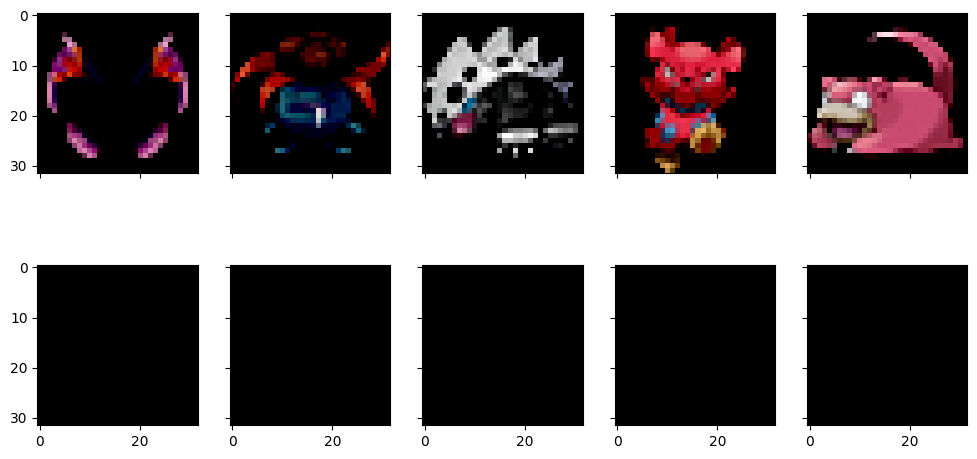

[Epoch 2, Iter 15/26] Loss: 0.681236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


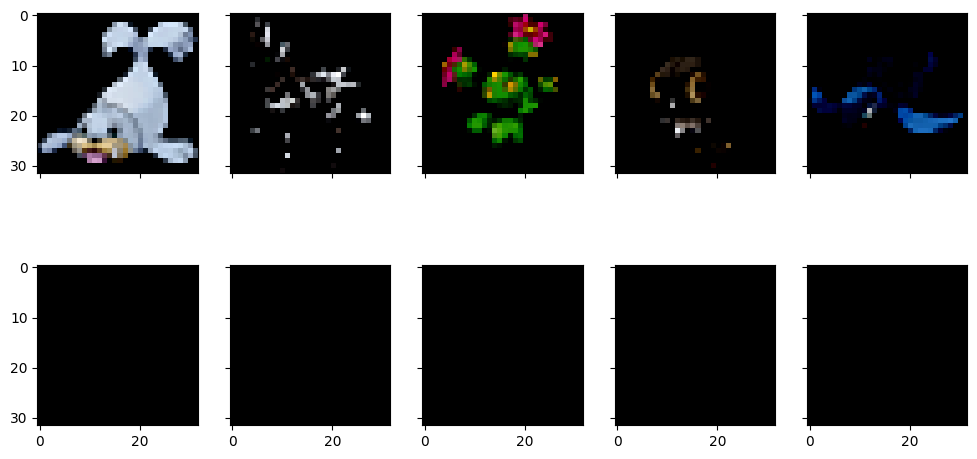

[Epoch 2, Iter 16/26] Loss: 0.664375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


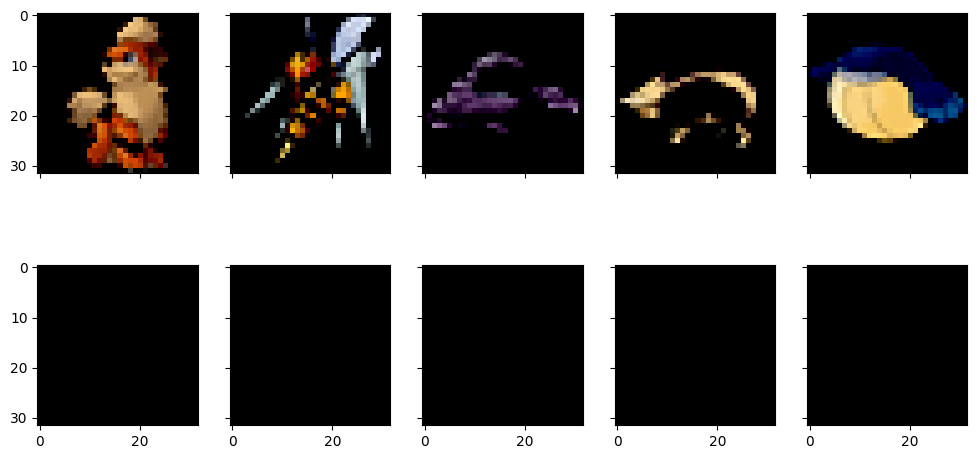

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 17/26] Loss: 0.675721


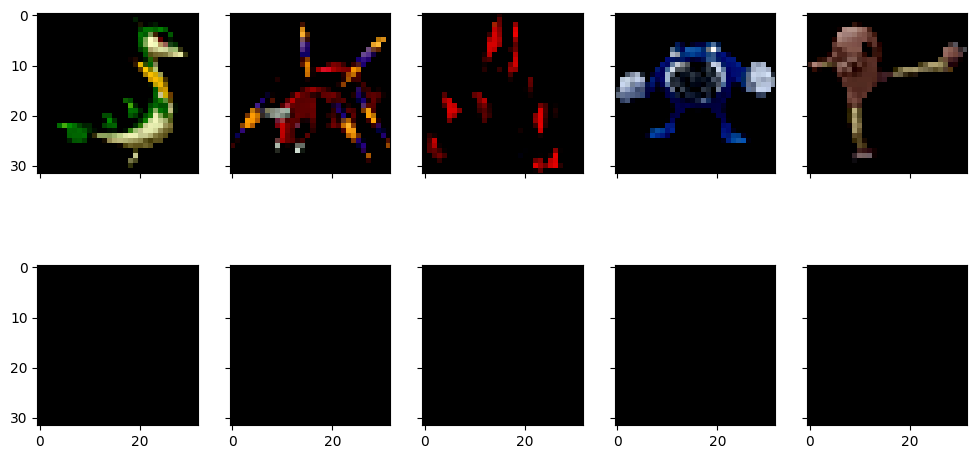

[Epoch 2, Iter 18/26] Loss: 0.669865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


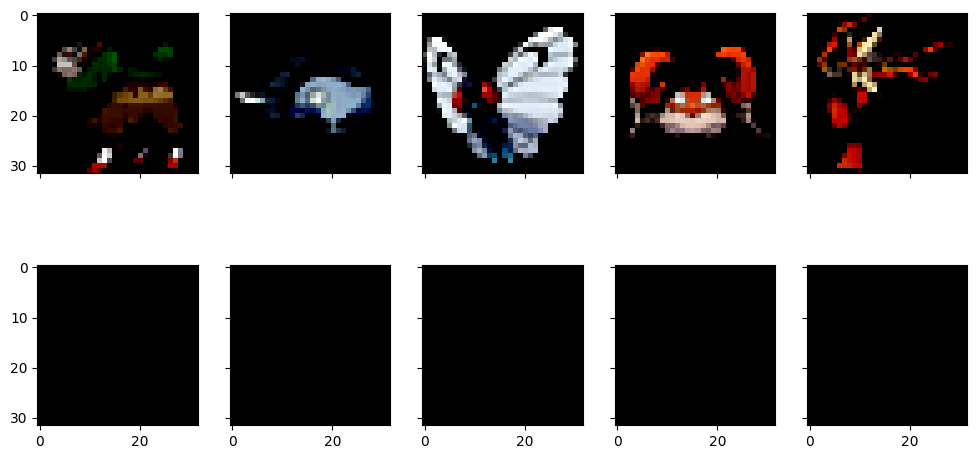

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 19/26] Loss: 0.662313


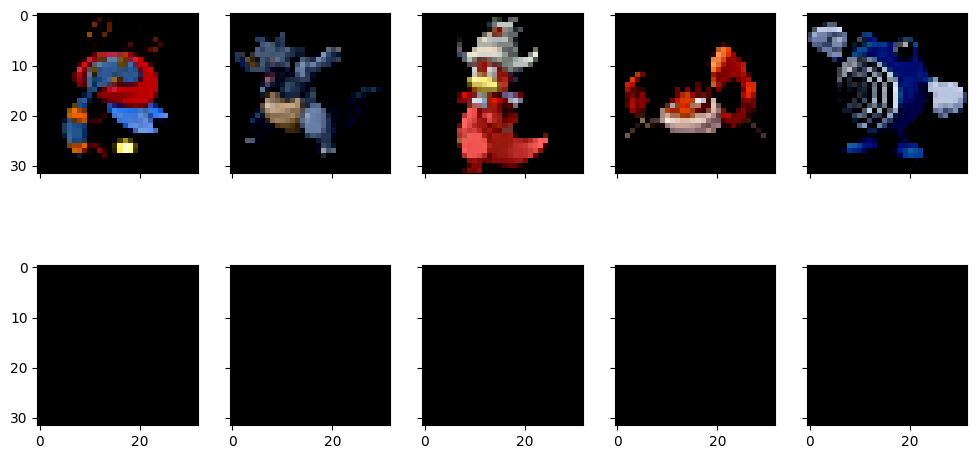

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 20/26] Loss: 0.646072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


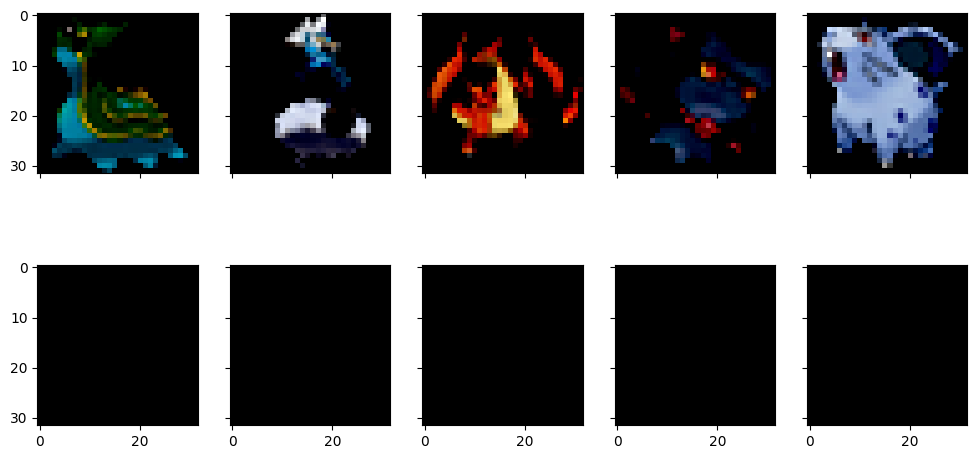

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 21/26] Loss: 0.683818


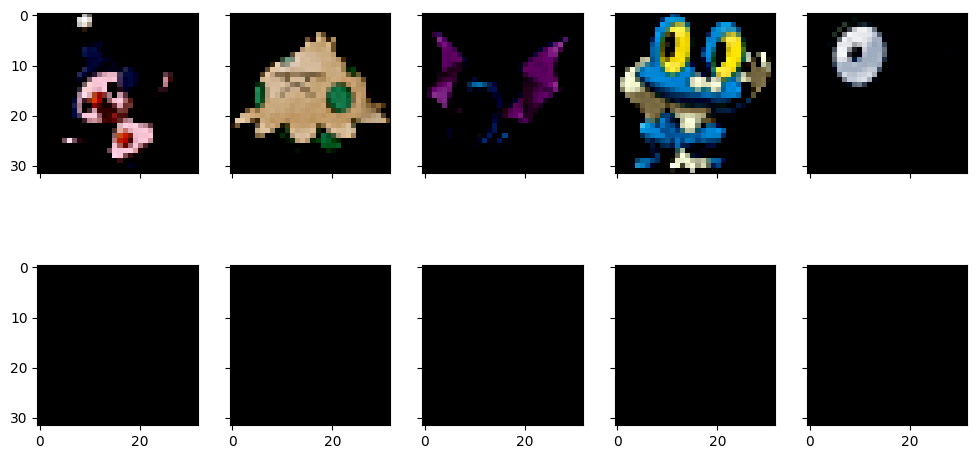

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 22/26] Loss: 0.640717


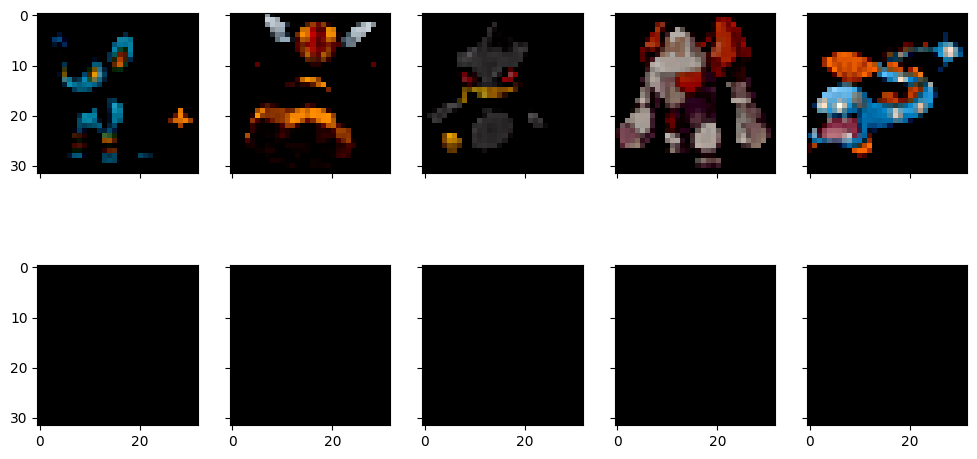

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2, Iter 23/26] Loss: 0.653382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


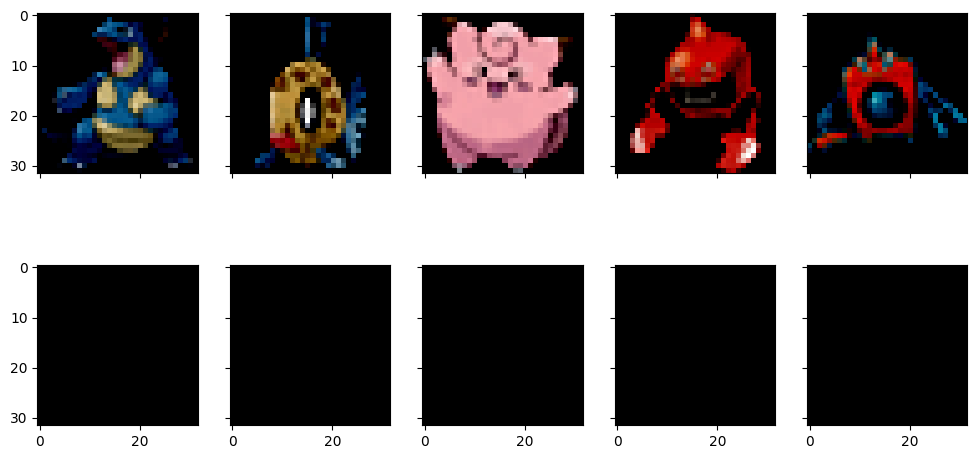

[Epoch 2, Iter 24/26] Loss: 0.671529


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


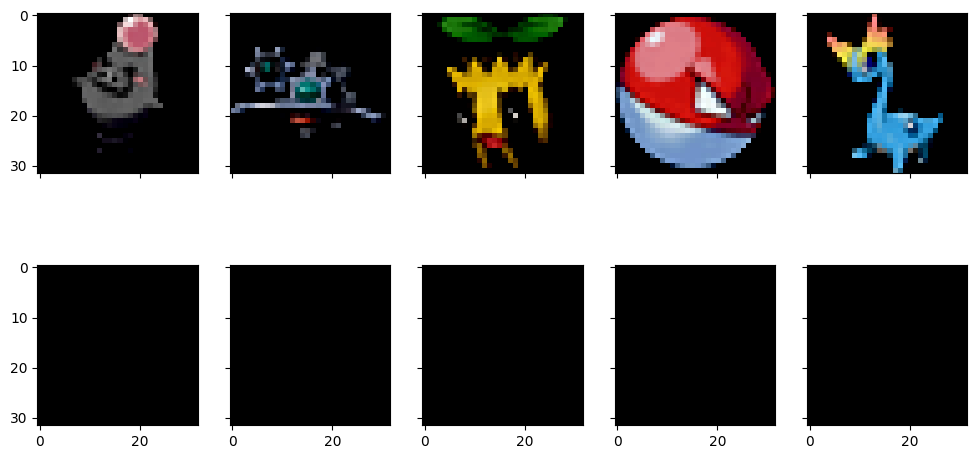

[Epoch 2, Iter 25/26] Loss: 0.685696


KeyboardInterrupt: 

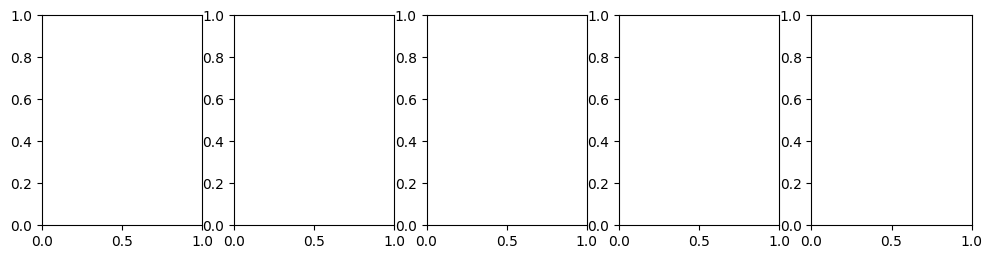

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function (MSE loss)
criterion = nn.MSELoss()

# Define the optimizer (Adam optimizer)
lr = 0.001
betas = (0.9, 0.999)
eps = 1e-08
optimizer = optim.Adam(autoencoder.parameters(), lr=lr, betas=betas, eps=eps)

# Train the autoencoder
num_epochs = 10
print_freq = 1  # Print loss every 10 iterations
plot_freq = 1  # Plot original and reconstructed images every 50 iterations

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Get the inputs
        inputs = data[0]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)

        # Compute the loss
        loss = criterion(outputs, inputs)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i + 1) % print_freq == 0:
            print('[Epoch %d, Iter %d/%d] Loss: %.6f' %
                  (epoch + 1, i + 1, len(train_loader),
                   running_loss / print_freq))
            running_loss = 0.0

        # Plot original and reconstructed images
        if (i + 1) % plot_freq == 0:
            fig, axes = plt.subplots(nrows=2,
                                     ncols=5,
                                     sharex=True,
                                     sharey=True,
                                     figsize=(12, 6))
            inputs_np = inputs.cpu().detach().numpy()
            outputs_np = outputs.cpu().detach().numpy()
            for j in range(5):
                axes[0][j].imshow(inputs_np[j].transpose(1, 2, 0))
                axes[1][j].imshow(outputs_np[j].transpose(1, 2, 0))
            plt.show()


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the loss function (MSE loss)
criterion = nn.MSELoss()

# Define the optimizer (Adam optimizer)
lr = 0.001
betas = (0.9, 0.999)
eps = 1e-08
optimizer = optim.Adam(autoencoder.parameters(), lr=lr, betas=betas, eps=eps)

# Train the autoencoder
num_epochs = 2
print_freq = 1  # Print loss every 1 iterations
plot_freq = 5  # Plot original and reconstructed images every 5 iterations

losses = []  # to store loss values at each iteration

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Get the inputs
        inputs = data[0]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)

        # Compute the loss
        loss = criterion(outputs, inputs)

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i + 1) % print_freq == 0:
            print('[Epoch %d, Iter %d/%d] Loss: %.6f' %
                  (epoch + 1, i + 1, len(train_loader),
                   running_loss / print_freq))
            losses.append(running_loss / print_freq)  # store the loss value
            running_loss = 0.0

        # Plot original and reconstructed images
        if (i + 1) % plot_freq == 0:
            fig, axes = plt.subplots(nrows=2,
                                     ncols=5,
                                     sharex=True,
                                     sharey=True,
                                     figsize=(12, 6))
            inputs_np = inputs.cpu().detach().numpy()
            outputs_np = outputs.cpu().detach().numpy()
            for j in range(5):
                axes[0][j].imshow(inputs_np[j].transpose(1, 2, 0))
                axes[1][j].imshow(outputs_np[j].transpose(1, 2, 0))
            plt.show()

# plot the loss values
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import math


def make_noise_schedule(num_steps, noise_schedule_type='linear'):
    if noise_schedule_type == 'linear':
        # Linear noise schedule: start with high noise and decrease it linearly
        return [math.sqrt(i / (num_steps - 1)) for i in range(num_steps)]
    elif noise_schedule_type == 'cosine':
        # Cosine noise schedule: start with high noise and decrease it using a cosine function
        return [
            math.sqrt(0.5 * (1 + math.cos(math.pi * i / num_steps)))
            for i in range(num_steps)
        ]
    else:
        raise ValueError(f"Unknown noise schedule type: {noise_schedule_type}")


noise_schedule = make_noise_schedule(1000, noise_schedule_type='linear')

def guided_diffusion_step(latent, diffusion_steps_left, noise_schedule,
                          denoise_fn):
    # Generate random noise with the same shape as the latent representation
    noise = torch.randn_like(latent) * noise_schedule[diffusion_steps_left - 1]

    # Mix the noise with the latent representation
    mixed_latent = latent + noise

    # Perform the diffusion process by running the mixed latent representation through the denoise function
    denoised_latent = denoise_fn(mixed_latent, diffusion_steps_left - 1)

    return denoised_latent


def guided_diffusion(latent, noise_schedule, denoise_fn, num_steps=1000):
    for i in range(num_steps):
        latent = guided_diffusion_step(latent, num_steps - i, noise_schedule,
                                       denoise_fn)
    return latent

In [ ]:
noise_schedule = make_noise_schedule(1000, noise_schedule_type='linear')

noise_schedule[0]

In [ ]:
class Denoise(nn.Module):

    def __init__(self):
        super(Denoise, self).__init__()

        # Define a small U-Net architecture with 2 downsample blocks and 2 upsample blocks
        self.down1 = nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.down2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.up1 = nn.ConvTranspose2d(64,
                                      64,
                                      kernel_size=4,
                                      stride=2,
                                      padding=1)
        self.up2 = nn.ConvTranspose2d(64,
                                      128,
                                      kernel_size=4,
                                      stride=2,
                                      padding=1)

    def forward(self, x, t):
        # Apply the downsample blocks
        x = self.down1(x)
        x = F.relu(x)
        x = self.down2(x)
        x = F.relu(x)

        # Apply the upsample blocks with noise injection
        noise = torch.randn_like(x) * math.sqrt(t)
        x = self.up1(x + noise)
        x = F.relu(x)
        noise = torch.randn_like(x) * math.sqrt(t)
        x = self.up2(x + noise)
        x = F.relu(x)

        return x


In [ ]:
def decode_latent(latent):
    # Define the decoder network
    decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid())

    # Pass the latent representation through the decoder network
    output = decoder(latent)

    # Reshape the output to the desired image shape
    output = output.view(1, 3, 32, 32)

    return output


In [ ]:
def decode_latent(latent):
    # Instantiate the decoder network
    decoder = Decoder()

    # Pass the latent representation through the decoder network
    output = decoder(latent)

    return output


In [ ]:
def postprocess(output):
    # Convert the output tensor to a NumPy array
    output = output.detach().cpu().numpy()

    # Convert the pixel values from [0, 1] to [0, 255] and round to the nearest integer
    output = np.round(output * 255).astype(np.uint8)

    # Transpose the tensor from (1, 3, 32, 32) to (32, 32, 3)
    output = np.transpose(output, (0, 2, 3, 1))

    # Display the output as an image
    plt.imshow(output.squeeze())
    plt.axis('off')
    plt.show()


In [ ]:
def main(image_path):
    # Load the input image
    input_image = load_image(image_path)

    # Preprocess the input image
    input_tensor = preprocess(input_image)

    # Encode the input image into a latent representation
    latent = encode_input(input_tensor)

    # Apply guided diffusion to the latent representation
    guided_latent = guided_diffusion(latent)

    # Decode the final latent representation into an output image
    output_tensor = decode_latent(guided_latent)

    # Postprocess the output image and display it
    postprocess(output_tensor)


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

# Define the batch size
batch_size = 64

# Define the number of epochs
num_epochs = 10

# Define the learning rate
learning_rate = 0.0002

# Define the device to use for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the dataset and data loader
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor()])
dataset = CIFAR10(root='./data',
                  train=True,
                  download=True,
                  transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the model and move it to the device
model = PixelArtGuidedDiffusion().to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Loop over the epochs
for epoch in range(num_epochs):
    # Loop over the batches in the data loader
    for batch_idx, (data, _) in enumerate(loader):
        # Move the input data to the device
        data = data.to(device)

        # Perform the forward pass
        input_tensor = preprocess(data)
        latent = encode_input(input_tensor)
        guided_latent = guided_diffusion(latent)
        output_tensor = decode_latent(guided_latent)

        # Compute the loss
        loss = loss_fn(output_tensor, input_tensor)

        # Zero the gradients, perform the backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Generate a new test picture every epoch to monitor the training
        if batch_idx == 0:
            test_input = load_image('./test_image.png')
            test_input_tensor = preprocess(test_input)
            test_latent = encode_input(test_input_tensor)
            test_guided_latent = guided_diffusion(test_latent)
            test_output_tensor = decode_latent(test_guided_latent)
            postprocess(test_output_tensor)

    # Print the loss at the end of each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')
